# Boosting on CGC Data

In [1]:
def load_cgc_metadata():
    import pandas as pd, os
    metadata = pd.DataFrame()

    for file in os.listdir(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\"):
        if "manifest" in file:
            if metadata.empty:
                metadata = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
            else:
                data = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
                metadata = pd.concat([metadata, data])

    metadata = metadata.reset_index(drop= True).drop_duplicates()

    return metadata

def load_cgc_data():
    import pandas as pd, os

    metadata = load_cgc_metadata()
    
    directory = os.path.dirname(os.path.dirname(os.getcwd())) + "\\Data\\GeneExpression\\Files\\"
    master = pd.DataFrame()

    for file in os.listdir(directory):
        tsv_file_path = directory + file

        df = pd.read_csv(tsv_file_path, sep='\t')
        df = pd.DataFrame(df.set_index("miRNA_ID")["reads_per_million_miRNA_mapped"]).rename(columns={"reads_per_million_miRNA_mapped":file}).T

        master = pd.concat([master,df])
    
    df = metadata.set_index("name").join(master).set_index("id")
        
    return df

In [2]:
df = load_cgc_data()

## Pre-processing

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Drop unknown vital status
df2 = df[df["vital_status"] != "Unknown"]

In [5]:
X = df.drop(columns = ["disease_type", "vital_status"])
binary_y = df["vital_status"].apply(lambda x: 1 if x == "Alive" else 0)
multiclass_y = df["disease_type"]


In [69]:
X_train, X_val, binary_y_train, binary_val = train_test_split(X, binary_y, train_size=0.8, random_state=4)
X_train2, X_test, binary_y_train2, binary_y_test = train_test_split(X_train, binary_y_train, train_size=0.7, random_state=4)
#X_train, X_test, multiclass_y_train, multiclass_y_test = train_test_split(X, multiclass_y, train_size=0.7, random_state=4)


## Binary ADA Boost
Here we will be using miRNA counts as predictors and vital status (aka whether the patient has survived the cancer (1) or not (0)) as the target.

In [61]:
from sklearn.ensemble import AdaBoostClassifier

In [70]:
binary_classifier = AdaBoostClassifier()
binary_classifier.fit(X_train2, binary_y_train2)

AdaBoostClassifier()

In [71]:
(binary_classifier.decision_function(X_test) >= 0)[:5]

array([False, False,  True,  True,  True])

In [72]:
binary_classifier.predict(X_test)[:5]

array([0, 0, 1, 1, 1], dtype=int64)

The decision function essentially gives us the weighted average of the weak classifiers whereas predict returns the sign of the decision function, which in the end is the class predicton.

In [73]:
def cm_mapper(actual, predictions):
    import numpy as np
    mapping = []
    for i in range(len(predictions)):

        if predictions[i]:
            if actual[i]:
                mapping.append("TP")
            else:
                mapping.append('FP')
        else:
            if actual[i]:
                mapping.append('FN')
            else:
                mapping.append('TN')

    return np.array(mapping)

In [75]:
import pandas as pd
weights = binary_classifier.decision_function(X_test)
predictions1 = binary_classifier.predict(X_test)
cm = cm_mapper(predictions1, binary_y_test)

results = pd.DataFrame({'Actual':binary_y_test, 'Predicted':predictions1, 'Weight':weights, "Outcome":cm})

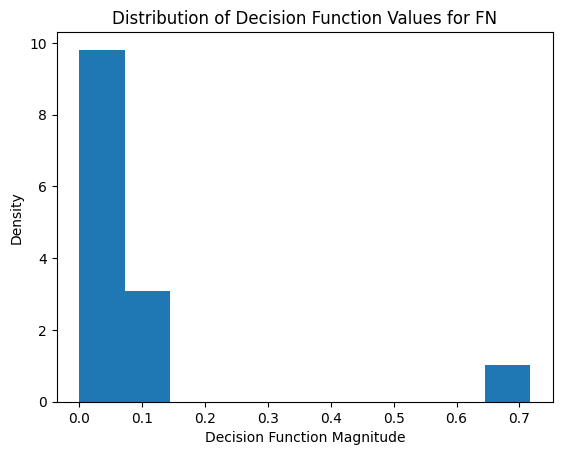

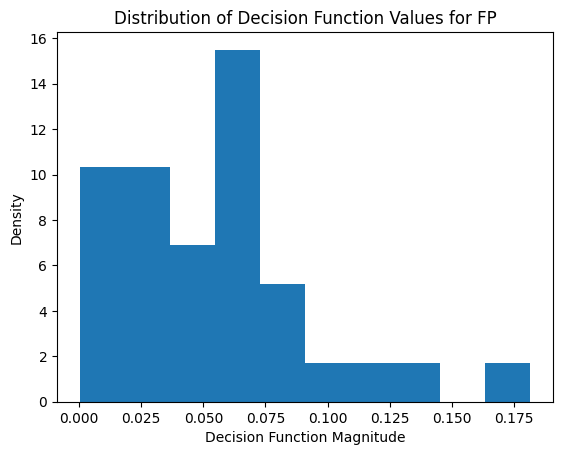

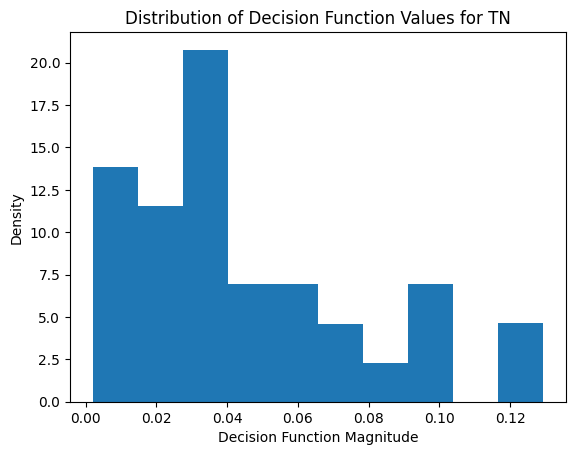

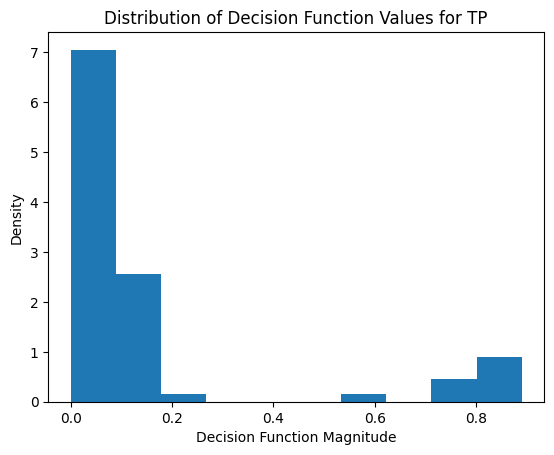

In [76]:
import matplotlib.pyplot as plt
groups = results.groupby('Outcome')
for name, group in groups:
    plt.hist(abs(group.Weight), density=True)
    plt.title("Distribution of Decision Function Values for " + name)
    plt.xlabel("Decision Function Magnitude")
    plt.ylabel("Density")
    plt.show()


If the magnitude of the decision function is high then you would expect that the model is very sure about the decision it is making. I would assume that these values would surely be true positives and true negatives. Looking at the graphs, it turns out that this assumption is not necessarily true

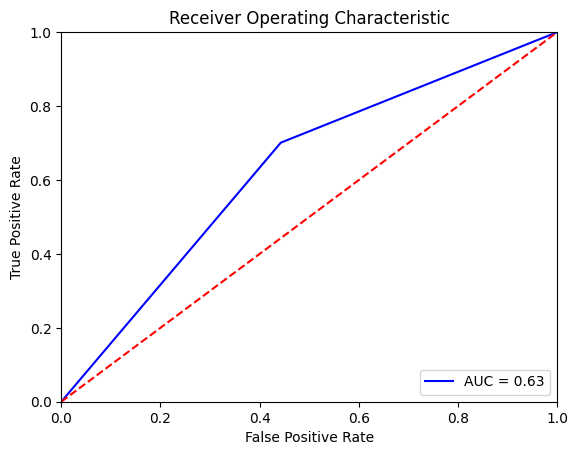

In [77]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(binary_y_test, predictions1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

print("Confusion Matrix:\n", confusion_matrix(binary_y_test, predictions1)) 
print("Accuracy = ", binary_classifier.score(X_test, binary_y_test))
print("Kappa = ", cohen_kappa_score(binary_y_test, predictions1))

Confusion Matrix:
 [[34 27]
 [32 75]]
Accuracy =  0.6488095238095238
Kappa =  0.25383920505871727


Our confusion matrix shows a poor accuracy but our kappa value is not awful.

The first attempt at boosting has not resulted in a very successful model.

### Hyperparameter Tuning

In [83]:
from sklearn.model_selection import cross_val_score

In [99]:
# Number of estimators

estimators = [10,50,100,150,200]
score = []

for n in estimators:

    classifier = AdaBoostClassifier(n_estimators= n)
    score.append(cross_val_score(classifier, X_train2, binary_y_train2).mean())
    

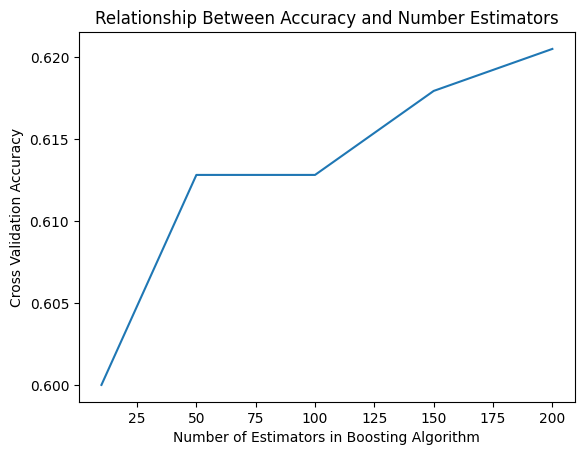

In [100]:
plt.plot(estimators, score)
plt.title("Relationship Between Accuracy and Number Estimators")
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Number of Estimators in Boosting Algorithm")
plt.show()

We increase our accuracy by roughly 0.01% per estimator which means (assuming linear effects) we would have to add 1000 estimators to get our accuracy from 60% to 70%.

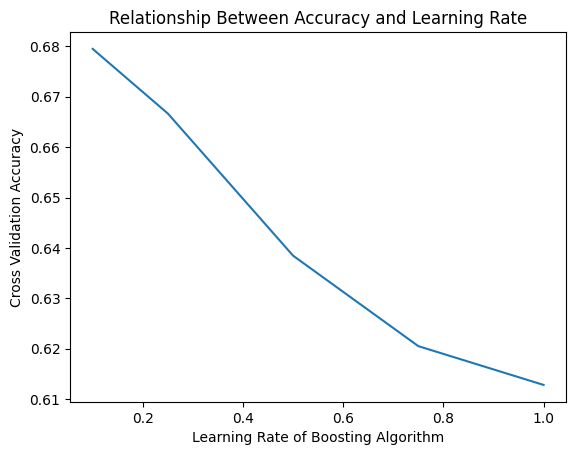

In [103]:
# Learning rate

rates = [0.1,0.25,0.5,0.75,1]
score = []

for r in rates:

    classifier = AdaBoostClassifier(learning_rate=r)
    score.append(cross_val_score(classifier, X_train2, binary_y_train2).mean())

plt.plot(rates, score)
plt.title("Relationship Between Accuracy and Learning Rate")
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Learning Rate of Boosting Algorithm")
plt.show()

Lowering learning rates give us a boost in accuracy. For our final model we will use a learning rate of 0.1

In [105]:
def plot_roc(real, predicted, lab):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, threshold2 = roc_curve(real, predicted)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = lab + ' AUC = %0.2f' % roc_auc)
    

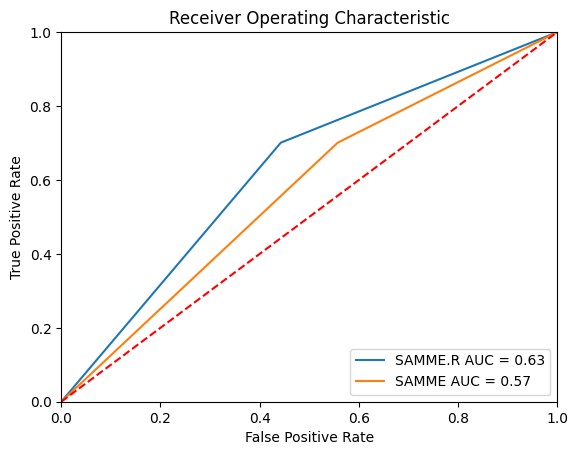

In [106]:
# SAMME vs SAMME.N

binary_classifier2 = AdaBoostClassifier(algorithm="SAMME")
binary_classifier2.fit(X_train2, binary_y_train2)

predictions2 = binary_classifier2.predict(X_test)

plot_roc(binary_y_test, predictions1, "SAMME.R")
plot_roc(binary_y_test, predictions2, "SAMME")

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [107]:
print("SAMME Results")

print("Confusion Matrix:\n", confusion_matrix(binary_y_test, predictions2)) 
print("Accuracy = ", binary_classifier2.score(X_test, binary_y_test))
print("Kappa = ", cohen_kappa_score(binary_y_test, predictions2))

SAMME Results
Confusion Matrix:
 [[27 34]
 [32 75]]
Accuracy =  0.6071428571428571
Kappa =  0.14457645425088717


Results are similar. SAMME.R outperforms slightly

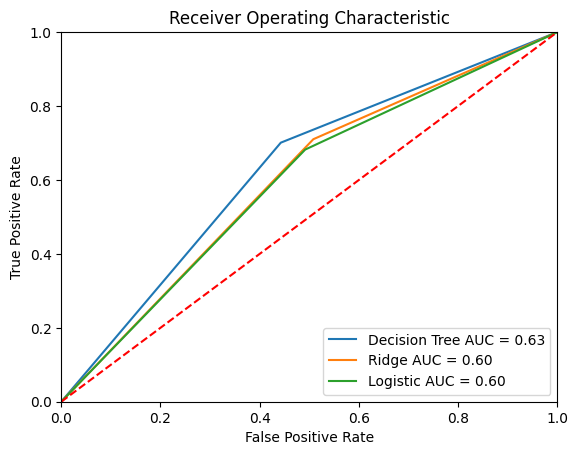

In [108]:
# Different classifier 
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import RidgeClassifier, LogisticRegression

Ridge_booster = AdaBoostClassifier(estimator=RidgeClassifier(),algorithm="SAMME")
Ridge_booster.fit(X_train2, binary_y_train2)
predictions3 = Ridge_booster.predict(X_test)

Logistic_booster = AdaBoostClassifier(estimator=LogisticRegression(max_iter=100))
Logistic_booster.fit(X_train2, binary_y_train2)
predictions4 = Logistic_booster.predict(X_test)

plot_roc(binary_y_test, predictions1, "Decision Tree")
plot_roc(binary_y_test, predictions3, "Ridge")
plot_roc(binary_y_test, predictions4, "Logistic")

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The decision tree outperforms the linear classifiers. Let's see if adding more depth to the decisions trees improves our accuracy (at the loss of interpretibility)

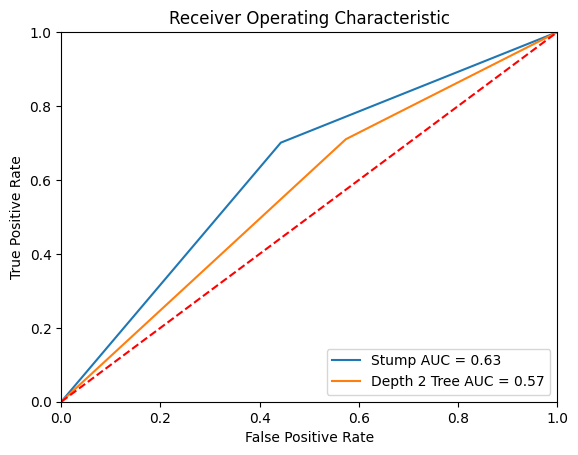

In [109]:
from sklearn.tree import DecisionTreeClassifier
binary_classifier3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))
binary_classifier3.fit(X_train2, binary_y_train2)

predictions5 = binary_classifier3.predict(X_test)

plot_roc(binary_y_test, predictions1, "Stump")
plot_roc(binary_y_test, predictions5, "Depth 2 Tree")

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Adding depth to the decision tree classifier does not improve the prediction accuracy. After all the hyperparameter tuning, our original model remains strong aside from the an reduction in the learning rate.

In [111]:
final_model = AdaBoostClassifier(learning_rate=0.1)
final_model.fit(X_train, binary_y_train)

final_predictions = final_model.predict(X_val)
from sklearn.metrics import confusion_matrix, cohen_kappa_score

print("Final Model Results")
print("Confusion Matrix:\n", confusion_matrix(binary_val, final_predictions)) 
print("Accuracy = ", binary_classifier.score(X_val, binary_val))
print("Kappa = ", cohen_kappa_score(binary_val, final_predictions))


Final Model Results
Confusion Matrix:
 [[ 7 47]
 [ 9 77]]
Accuracy =  0.6
Kappa =  0.0287413280475719


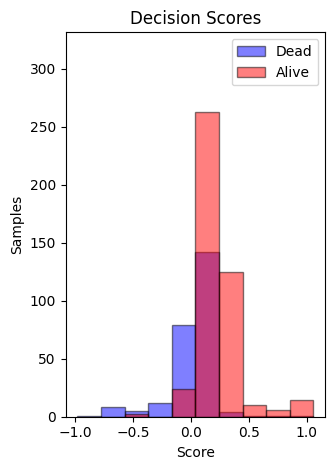

In [138]:
# Visualization taken from sklearn
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py


twoclass_output = final_model.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
class_names = ["Dead", "Alive"]
plot_colors = "br"
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[binary_y == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label=n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

## Variable Importance

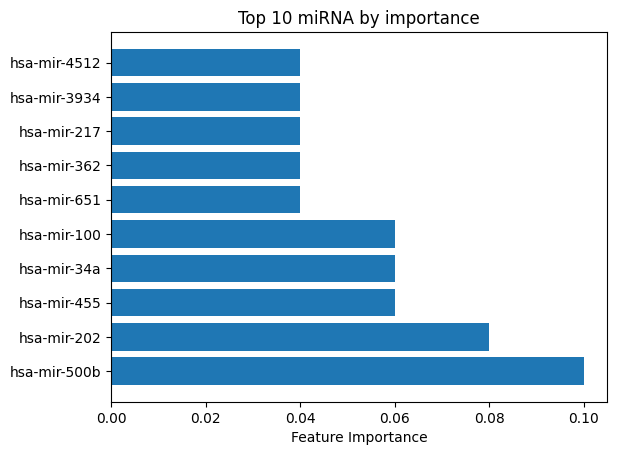

In [136]:
top10_important = pd.DataFrame({"miRNA_id":final_model.feature_names_in_, "Importance":final_model.feature_importances_}).sort_values("Importance", ascending=False).head(10)
plt.barh(top10_important["miRNA_id"], top10_important["Importance"])
plt.title("Top 10 miRNA by importance")
plt.xlabel("miRNA ID")
plt.xlabel("Feature Importance")
plt.show()